# Criptografia - Practica RSA

##### Membres:
##### Juli Sahun i Victor Pla Sanchis

### 1 - BlockChain

In [1]:
import math
import hashlib
import copy
import sympy
import random
import time
import pickle

Clase block

In [16]:
d = 16
class block:
    def __init__(self):
        self.block_hash = 0
        self.previous_block_hash = 0
        self.transaction = transaction(150, rsa_key())
        self.seed = 12
    
    def genesis(self, transaction):
        self.transaction = transaction
        self.previous_block_hash = 0
        self.getBlockHash(transaction)

    def next_block(self, transaction):
        self.transaction = transaction
        self.previous_block_hash = self.block_hash
        self.getBlockHash(transaction)
    
    def verify_block(self):
        prevCheck = self.previous_block_hash < 2**(256-d)
        transCheck = self.transaction.verify()
        currCheck = self.block_hash < 2**(256-d) and self.getHash(self.seed, self.transaction) == self.block_hash
        return prevCheck and transCheck and currCheck
    
    def getBlockHash(self, transaction):
        seed = 0
        h = self.getHash(seed, transaction)
        while h >= 2**(256-d):
            seed = seed + 1
            h = self.getHash(seed, transaction)
        self.seed = seed
        self.block_hash = h

    def getHash(self, seed, transaction):
        e = str(self.previous_block_hash)
        e += str(self.transaction.public_key.publicExponent)
        e += str(self.transaction.public_key.modulus)
        e += str(self.transaction.message)
        e += str(self.transaction.signature)
        e += str(seed)
        return int(hashlib.sha256(e.encode()).hexdigest(), 16)


Clase rsa_public_key

In [3]:
class rsa_public_key:
    def __init__(self, rsa_key):
        self.publicExponent = rsa_key.publicExponent
        self.modulus = rsa_key.modulus

    def verify(self, message, signature):
        return pow(signature,self.publicExponent,self.modulus) == message

Clase block_chain

In [4]:
class block_chain:
    def __init__(self, transaction):
        b = block()
        b.genesis(transaction)
        self.list_of_blocks = [b]
        

    def add_block(self, transaction): 
        newBlock = copy.deepcopy(self.list_of_blocks[-1])
        newBlock.next_block(transaction)
        self.list_of_blocks.append(newBlock)
    
    def verify(self):
        if self.list_of_blocks[0].previous_block_hash != 0:
            return False
        for i in range(len(self.list_of_blocks)):
            if (not self.list_of_blocks[i].verify_block()):
                return False
            if i > 0 and self.list_of_blocks[i].previous_block_hash != self.list_of_blocks[i-1].block_hash:
                return False
        return True


Clase transaction

In [5]:
class transaction:
    def __init__(self, message, RSAkey):
        self.public_key = rsa_public_key(RSAkey)
        self.message = message
        self.signature = RSAkey.sign(message)
    
    def verify(self):
        return self.public_key.verify(self.message, self.signature)

Clase rsa_key

In [14]:
class rsa_key:
    def check_congruent(self,a,c,m,debug=True):
        if (a % m) != (c % m):
            print("Congruent check not passed.")
            exit(1)
        else:
            if debug:
                print("Congruent check passed.")
            return True

    def __init__(self, bits_modulo=2048, e=2**16+1):
        self.primeP, self.primeQ =  self.getPrimes(e, bits_modulo)
        self.phi = (self.primeP-1)*(self.primeQ-1)
        self.publicExponent = e
        self.privateExponent = int(sympy.mod_inverse(e,self.phi))
        self.modulus = self.primeP*self.primeQ
        self.privateExponentModulusPhiP = int(self.privateExponent % (self.primeP-1))
        self.privateExponentModulusPhiQ = int(self.privateExponent % (self.primeQ-1))
        self.inverseQModulusP = int(sympy.mod_inverse(self.primeQ, self.primeP))

        self.check_congruent(self.privateExponent * self.publicExponent, 1, self.phi,debug=False)
        self.check_congruent(self.privateExponentModulusPhiP, self.privateExponent, self.primeP-1,debug=False)
        self.check_congruent(self.privateExponentModulusPhiQ, self.privateExponent, self.primeQ-1,debug=False)
        self.check_congruent(self.inverseQModulusP * self.primeQ, 1, self.primeP,debug=False)
    
    def sign(self, message):
        a = pow(message, self.privateExponentModulusPhiP, self.primeP)
        b = pow(message, self.privateExponentModulusPhiQ, self.primeQ)
        qq = self.inverseQModulusP * self.primeQ
        pp = 1 - qq
        return pp*b + qq*a
    
    def sign_slow(self, message):
        return pow(message, self.privateExponent, self.modulus)
    
    def verify(self, message, signature):
        return pow(signature,self.publicExponent,self.modulus) == message


    def getPrimes(self,e, bits_modulo):
        while True:
            p = random.getrandbits(bits_modulo)
            while not sympy.isprime(p):
                p = random.getrandbits(bits_modulo)
            q = random.getrandbits(bits_modulo)
            while not sympy.isprime(q) or p == q:
                q = random.getrandbits(bits_modulo)
            if  math.gcd(e,p*q) == 1 and e < (p-1)*(q-1):
                return int(p), int(q)


### Taules comparatives entre firma amb TCR i sense TCR

Per poder comparar els dos metodes implementats per firmar, firmarem 100 missatges amb els dos metodes per rsa de 512, 1024, 2048 i 4096 bits

In [17]:
meanTimes = {}
meanSlowTimes = {}

In [27]:
## DISCLAIMER: Ejecutar el siguiente código puede tardar mucho tiempo. (12 mins aprox)
for bits in [512, 1024, 2048, 4096]:
    print(bits)
    a = rsa_key(bits_modulo=bits)
    times = []
    slow_times = []
    for i in range(100):
        m = random.randint(0, 1000)

        start = time.time()
        a.sign(m)
        end = time.time()

        start_slow = time.time()
        a.sign_slow(m)
        end_slow = time.time()

        times.append(end-start)
        slow_times.append(end_slow-start_slow)

    meanTimes[bits] = sum(times)/len(times)
    meanSlowTimes[bits] = sum(slow_times)/len(slow_times)

512
1024
2048
4096


In [ ]:
print(meanTimes)
print(meanSlowTimes)

In [8]:
#valores obtenidos HardCodeados
meanTimes = {512: 0.0023760008811950684, 1024: 0.01295459270477295, 2048: 0.08876752376556396, 4096: 0.6792355799674987}
meanSlowTimes = {512: 0.007959756851196289, 1024: 0.0431899094581604, 2048: 0.4139524507522583, 4096: 3.043053641319275}

Mostrem una grafica i taula comparativa

<function matplotlib.pyplot.show(close=None, block=None)>

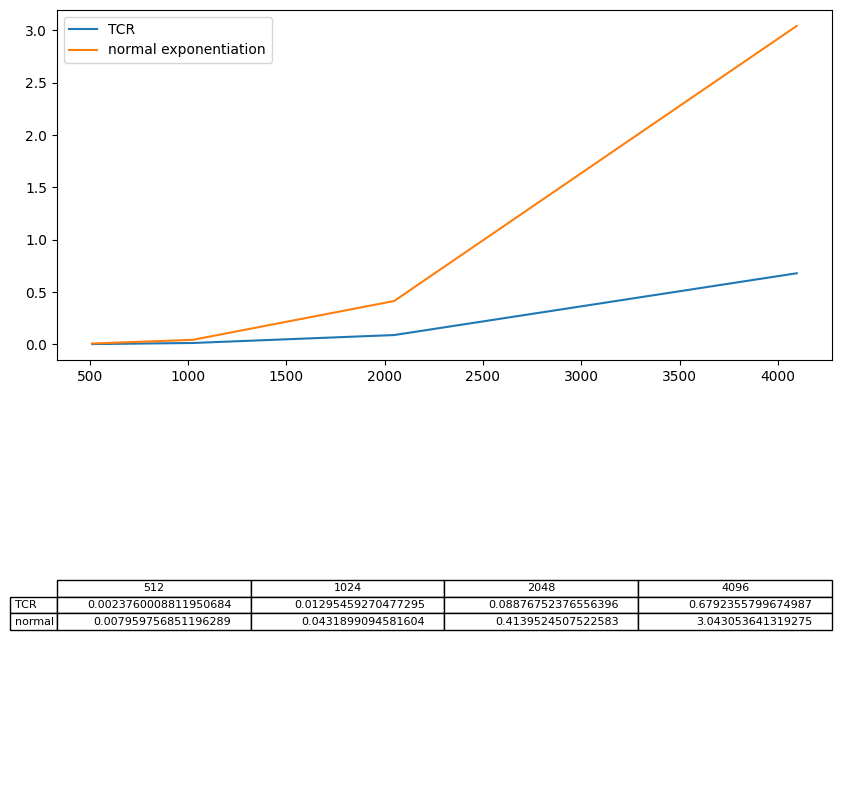

In [18]:
import matplotlib.pyplot as plt
bits = [512, 1024, 2048, 4096]
fig, axs =plt.subplots(2,1,figsize=(10, 10))
y1 = meanTimes.values()
axs[0].plot(bits, y1, label = "TCR")

x2 = bits
y2 = meanSlowTimes.values()
axs[0].plot(bits, y2, label = "normal exponentiation")
axs[0].legend(loc="upper left")

axs[1].axis('off')
axs[1].table(cellText= [list(meanTimes.values()), list(meanSlowTimes.values())], rowLabels=['TCR', 'normal'], colLabels=[512,1024,2048,4096], loc='center')

plt.show

Com podem veure, el teorema chines de residuu es clarament millor que la exponenciació modular, això es gracies a que el TCR realitza operacions amb nombres molt mes petits. Metre que la exponenciacio modular normal, realitza una exponenciacio modular amb el modul (de 2048 bits), el TCR realitza 2 exponenciacions modulars amb nombre de l'ordre de 1024 bits. Tot i fer mes operacions, al ser aquestes entre nombres mes petits fa que siguin més rapides.

Aquesta diferencia s'accentua com mes gran son els nombres, ja que el TCR es veu mes beneficiat.

Generamos dos cadenas de 100 bloques. La primera sera valida y la segunda solo sera valida hasta el bloque 42.

In [17]:
a = rsa_key()
t = transaction(150, a)

print('done')
bc = block_chain(t)
for i in range(100):
    bc.add_block(transaction(i, a))

with open('validChain.pickle', 'wb') as file:
    pickle.dump(bc, file)

bc = block_chain(t)
for i in range(100):
    if i < 42:
        bc.add_block(transaction(i,a))
    else:
        bc.list_of_blocks.append(block())

with open('invalidChain.pickle', 'wb') as file:
    pickle.dump(bc, file)

done
